# Monte Carlo Optimisation

## Code From Class

In [1]:
import random

def generateData(machines=4, jobs=7, seed=0):
    PROC = [ [ 0 for m in range(machines) ] for j in range(jobs) ]
    random.seed(seed)
    for j in range(jobs):
        for m in range(machines):
            PROC[j][m] = random.randint(1,9)
    return PROC

In [2]:
import pulp

def IP(PROC):

    steps = [ len(job) for job in PROC ]
    assert(min(steps)==max(steps))
    N_MACHINES = len(PROC[0])
    N_JOBS = len(PROC)


    def val(x):
        return int(pulp.value(x))

    def proc(job, machine):
        return pulp.lpSum( [ PROC[j][machine] * JJ[job][j] for j in range(N_JOBS) ] ) 

    JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)), lowBound=0, upBound=1, cat='Integer')
    Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')

    prob = pulp.LpProblem("JobScheduling",pulp.LpMinimize)
    prob += Stop[N_JOBS-1][N_MACHINES-1]

    # JJ is a permutation of the jobs
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ JJ[j][jj] for jj in range(N_JOBS) ] ) == 1
        prob += pulp.lpSum( [ JJ[jj][j] for jj in range(N_JOBS) ] ) == 1

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum( [ Idle[ji][m] + proc(ji, m) for ji in range(j) ] ) + Idle[j][m] == Start[j][m]

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum( [ Wait[j][mi] + proc(j, mi) for mi in range(m) ] ) + Wait[j][m] == Start[j][m]

    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            prob += Start[j][m] + proc(j,m) == Stop[j][m]

    solvers = pulp.listSolvers(onlyAvailable=True) 
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    acc = []
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if pulp.value(JJ[j][jj])==1:
                acc.append(jj)
                
    return acc, int(pulp.value(prob.objective))

In [3]:
import numpy as np

def totalTime(PROC, seq, log=False):
    
    def isPermutation(seq):
        for i in range(len(seq)):
            if i not in seq:
                return False
        return True
    
    steps = [ len(job) for job in PROC ]
    assert(len(PROC) == len(seq))
    assert(isPermutation(seq))
    assert(min(steps)==max(steps))
    n_machines = len(PROC[0])
    n_jobs = len(PROC)
    wait = np.zeros([n_jobs, n_machines], dtype=int)
    idle = np.zeros([n_jobs, n_machines], dtype=int)
    start = np.zeros([n_jobs, n_machines], dtype=int)
    stop  = np.zeros([n_jobs, n_machines], dtype=int)
    proc = np.zeros([n_jobs, n_machines], dtype=int)
    for job in range(n_jobs):
        proc[job] = PROC[seq[job]]
    for job in range(n_jobs):
        for machine in range(n_machines):
            start[job, machine] = max(stop[job-1, machine] if job>0 else 0, stop[job, machine-1] if machine>0 else 0)
            wait[job, machine] = start[job, machine] - (stop[job, machine-1] if machine>0 else 0)
            idle[job, machine] = start[job, machine] - (stop[job-1, machine] if job>0 else 0)
            stop[job, machine] = start[job, machine] + proc[job, machine]

    if log:

        row = '|---------|'
        for m in range(n_machines):
            row += f"------------|" \
                    f"------------|"
        print(row)
        
        row = '|         |'
        for m in range(n_machines):
            row += f"            |" \
                    f" Machine: {m:1d} |"
        print(row)
        
        for j in range(n_jobs):
            
            row = '|---------|'
            for m in range(n_machines):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Idle: {idle[j,m]:4d} |"
            print(row)
            
            row = '|---------|'
            for m in range(n_machines):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Start:{start[j,m]:4d} |"  
            print(row)
            
            row = f'| Job: {seq[j]:2d} |'
            for m in range(n_machines):
                row += f" Wait: {wait[j,m]:4d} | " \
                       f"Proc: {proc[j,m]:4d} |"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Stop: {stop[j,m]:4d} |"  
            print(row)
            
        row = '|---------|'
        for m in range(n_machines):
            row += f"------------|" \
                    f"------------|"
        print(row)

    
    return stop[n_jobs-1, n_machines-1]                                                       

## Generate Data

In [4]:
PROC = generateData(jobs = 100, seed=9525)

## IP Solution

Time for IP solution is below

In [5]:
seq, proctime = IP(PROC)
totalTime(PROC, seq)

513

## Monte-Carlo Implementation

Psuedo Code:

Pick a random order --> pick another random order of jobs --> compare times --> Repeat until either all orders are calculated or X orders tested

In [6]:
import random

def shuffle_list(unshuffled):
    shuffled = unshuffled
    for i in range(len(unshuffled)-1, 0, -1):
        
            # Pick a random index from 0 to i
            j = random.randint(0, i )

            # Swap arr[i] with the element at random index
            shuffled[i], shuffled[j] = unshuffled[j], unshuffled[i]
    return shuffled

def monte_carlo(PROC,N = 10 ):
    current_order = []
    for i in range(len(PROC)):
        current_order.append(i)
        current_order = sorted(current_order, key=lambda x: random.random())
    current_best = totalTime(PROC,current_order)

    # Generate New Order
    for _ in range(N):
        new_order = shuffle_list(current_order)
        new_time = totalTime(PROC,new_order)
        if(current_best > new_time):
            current_order = new_order
            current_best = new_time

    
    return current_order,current_best

def monte_carlo_2(PROC,N = 10 ):
    current_order = []
    for i in range(len(PROC)):
        current_order.append(i)
        current_order = sorted(current_order, key=lambda x: random.random())
    current_best = totalTime(PROC,current_order)

    # Generate New Order
    for _ in range(N):
        new_order = sorted(current_order, key=lambda x: random.random())
        new_time = totalTime(PROC,new_order)
        if(current_best > new_time):
            current_order = new_order
            current_best = new_time

    
    return current_order,current_best


current_order,current_best = monte_carlo(PROC,N=10000)
current_order_mc2,current_best_mc2 = monte_carlo_2(PROC,N=10000)
#print(f"Current order is: {current_order}, with time: {current_best}")
print(f"Monte Carlo V1 Time: {current_best}")
print(f"Monte Carlo V2 Time: {current_best_mc2}")



Monte Carlo V1 Time: 521
Monte Carlo V2 Time: 515


## Simulation for various Job Counts

In [7]:
import matplotlib.pyplot as plt

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame(columns=("Job Count","Monte-Carlo V1 Time","Monte-Carlo V2 Time","IP Time"))

for i in range(1,51):
    PROC = generateData(machines=4, jobs=i, seed=9525)    
    #Monte Carlo 1
    mc_seq, mc_proctime = monte_carlo(PROC,N=10000)
    mc_time = totalTime(PROC, mc_seq)
    # Monte Carlo 2
    mc2_seq, mc2_proctime = monte_carlo_2(PROC,N=10000)
    mc2_time = totalTime(PROC, mc2_seq)
    # IP
    ip_seq, ip_proctime = IP(PROC)
    ip_time = totalTime(PROC, ip_seq)
    if (mc_time<ip_time):
        raise(ValueError("Monte-Carlo Time Less Than IP Time"))
    comparison_df.loc[len(comparison_df.index)] = [i, mc_time,mc2_time, ip_time] 



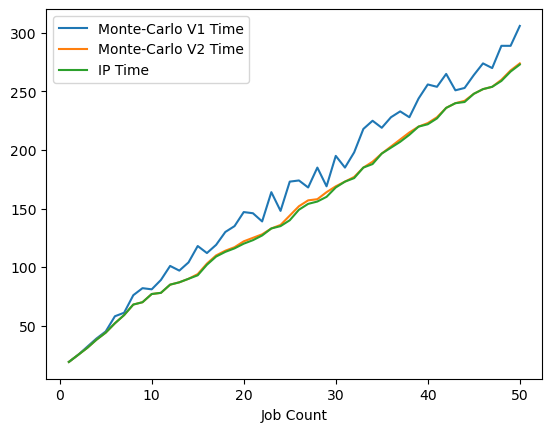

In [9]:
comparison_df.plot.line(x='Job Count',y=['Monte-Carlo V1 Time','Monte-Carlo V2 Time','IP Time'])
plt.savefig('output_figures/Monte-Carlo_comparison_totals.png')

In [10]:
comparison_df.loc[:,'Delta V1'] = comparison_df['Monte-Carlo V1 Time'] - comparison_df['IP Time']
comparison_df.loc[:,'Delta V2'] = comparison_df['Monte-Carlo V2 Time'] - comparison_df['IP Time']


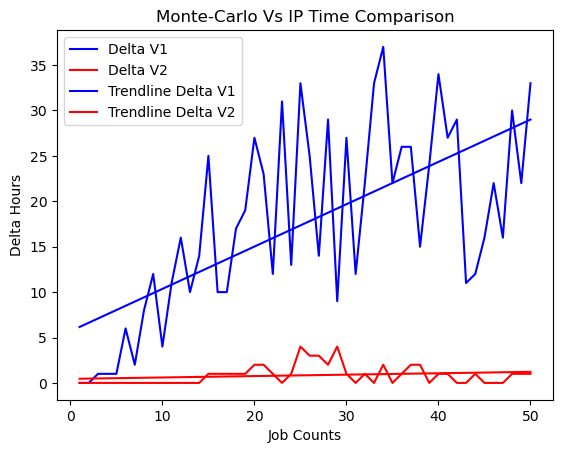

In [11]:
# Add in Trendline for Graphing purposes
polyfit_values = np.polyfit(x = comparison_df['Job Count'],y = comparison_df['Delta V1'],deg =1)
points = np.poly1d(polyfit_values)
comparison_df.loc[:,'Trendline Delta V1'] = points(comparison_df.loc[:,'Job Count'])

# Trendline MC V2
polyfit_values_v2 = np.polyfit(x = comparison_df['Job Count'],y = comparison_df['Delta V2'],deg =1)
points_v2 = np.poly1d(polyfit_values_v2)
comparison_df.loc[:,'Trendline Delta V2'] = points_v2(comparison_df.loc[:,'Job Count'])


# Plot graph of time delta and include the line of best fit to show slope
comparison_df.plot.line(x='Job Count',y=['Delta V1','Delta V2','Trendline Delta V1','Trendline Delta V2',],ylabel = 'Delta Hours',xlabel = 'Job Counts',title = "Monte-Carlo Vs IP Time Comparison",color=['b','r','b','r'])
plt.savefig('output_figures/Monte-Carlo_comp_delta.png')

In [12]:
comparison_df.to_excel("output_excels/Monte-Carlo_Comparison.xlsx")

Job Counts            999.000000
Estimated Delta V1    471.350204
Estimated Delta V2     15.892437
Name: 999, dtype: float64

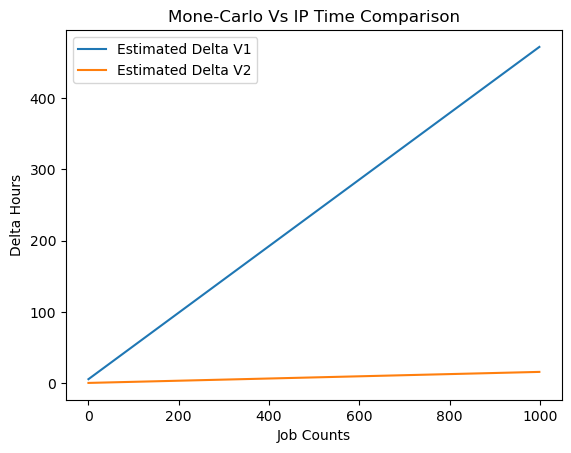

In [13]:
extrapolate = pd.DataFrame()
extrapolate.insert(0,'Job Counts',range(0,1000))
extrapolate.loc[:,'Estimated Delta V1'] = points(extrapolate.loc[:,'Job Counts'])
extrapolate.loc[:,'Estimated Delta V2'] = points_v2(extrapolate.loc[:,'Job Counts'])

extrapolate.plot.line(x='Job Counts',y=['Estimated Delta V1','Estimated Delta V2'],ylabel = 'Delta Hours',xlabel = 'Job Counts',title = "Mone-Carlo Vs IP Time Comparison")
extrapolate.loc[999]

## Time Taken for 1,000 jobs to be used with extrapolation table 

Commented as run time is long, see picture in outpur_figures for reference

In [ ]:
#PROC = generateData(jobs = 1000, seed=9525)
#seq, proctime = IP(PROC)
#totalTime(PROC, seq)

In [17]:
PROC = generateData(jobs = 1000, seed=9525)
seq, proctime = monte_carlo_2(PROC,N=10000)
totalTime(PROC, seq)

4994